# An In-depth Exploration of US Job Market by analyzing LinkedIn Job Postings using Natural Language Processing Techniques

## Data ingestion and preprocesing
We firstly need to read the webscraped dataset and explore its contents before we begin the analysis.
For a better understanding of one domain we will focus on the jobs regarding the IT industry.

In [ ]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from torchtext.vocab import GloVe
from transformers import BertTokenizer, BertModel
import torch
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from scipy.stats import mode
from sklearn.decomposition import LatentDirichletAllocation
import ast
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
import utils

/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Read the dataset
data = pd.read_csv('/Users/juliabarsow/Desktop/thesis/project_code/postings.csv')

In [13]:
# Check how many descriptions are missing as this is the most important column
print("Missing rows of description: ",data['description'].isnull().sum())

# Drop rows with missing descriptions
data = data.dropna(subset=['description'])

Missing rows of description:  7


In [14]:
# List of titles to take into account in our project
titles_to_classify = [
    'Full Stack Engineer',
    'Java Architect',
    'Intern- Business Analytics',
    'Frontend Engineer',
    'Machine Learning Engineer',
    'Junior Project Manager',
    'Azure Data Engineer',
    'Sr. Project Engineer',
    'Junior Business Analyst',
    'Cloud / .NET Developer',
    'Enterprise Data & Analytics Infrastructure Manager',
    'Computer Scientist',
    'DevOps Engineer',
    'Front end specialist',
    'Project Engineer',
    'Data Architect',
    'Data Analyst',
    'Java architect / Lead Java developer',
    'Enterprise Data & Analytics Infrastructure Manager',
    'Senior Software Engineer',
    'Web Developer',
    'Software Implementation Program Manager',
    'Test Engineer',
    'Sr Software Engineer',
    'IT QA Engineer II',
    'Sr. Business Analyst/Tester',
    'Senior Developer – React Native',
    'Cloud DevOps Engineer',
    'Senior Analyst, Data & Analytics',
    'Senior Business Analyst',
    'Engineering Project Manager / Project Manager',
    'Java full Stack Engineer',
    'backend Java developer',
    'Data Science Software Engineer',
    'Data Engineer/ETL'
]

# Filter the dataset to include only the specified titles
data = data[data['title'].isin(titles_to_classify)].reset_index(drop=True)

<Axes: title={'center': 'Job Title Distribution'}, xlabel='title'>

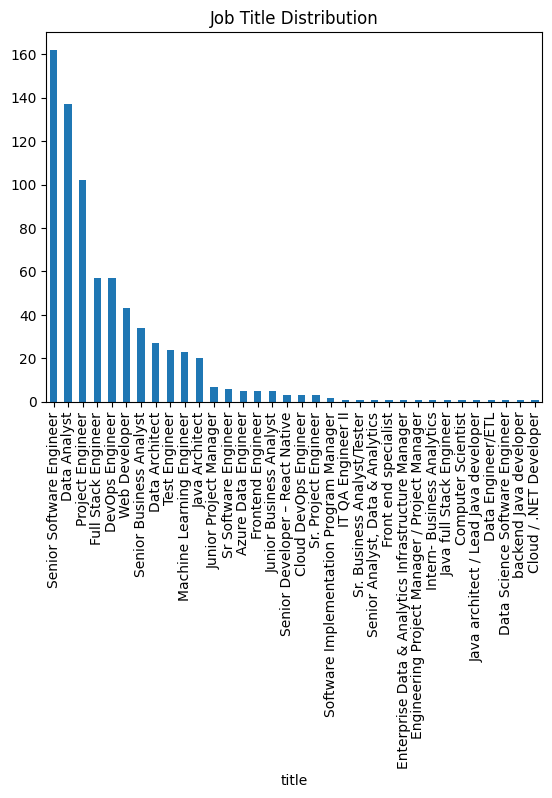

In [15]:
data['title'].value_counts().plot(kind='bar', title='Job Title Distribution')

In [16]:
# Make a copy of dataset for further processing and save only title and description columns
df = data.copy()
df = df[['job_id', 'title', 'description']]

In [17]:
df = utils.classify_job_titles(df)

<Axes: title={'center': 'Job Type Distribution'}, xlabel='general job classification'>

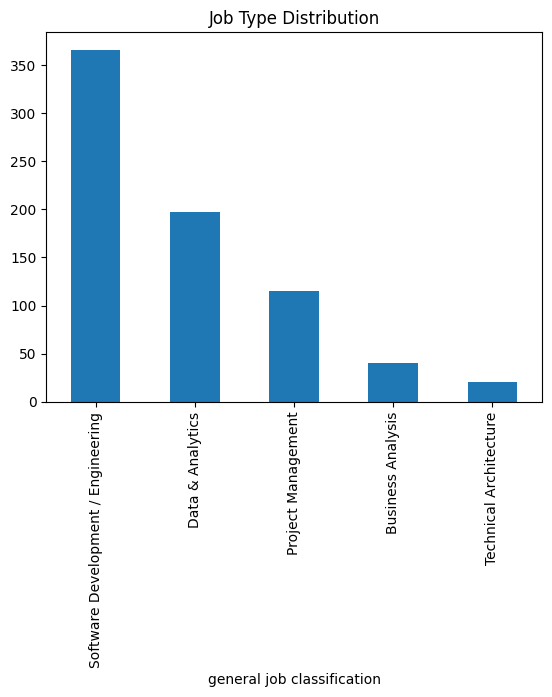

In [18]:
df['general job classification'].value_counts().plot(kind='bar', title='Job Type Distribution')

In [19]:
df['general job classification'].value_counts(normalize=True)

general job classification
Software Development / Engineering    0.495264
Data & Analytics                      0.266576
Project Management                    0.155616
Business Analysis                     0.054127
Technical Architecture                0.028417
Name: proportion, dtype: float64

In [20]:
df.shape

(739, 4)

## Skill Extraction and Clustering - Named entity recognition

#### Objective: Extract required skills from job descriptions and cluster them to identify common skill sets across industries.
#### We will use Ollama: https://ollama.com/ for the skill extraction

In [ ]:
# Run these commands in terminal to set up ollama and run the model
!pip install ollama
!python3 -m ollama pull llama3.2
!python3 -m ollama run granite3.2:8b

In [21]:
df_skills = utils.append_skills_requirements(df)

Processing row 1/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 2/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 3/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 4/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 5/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 6/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 7/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 8/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 9/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 10/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 11/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 12/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 13/739...
--- Sending request to O

In [22]:
# make a pickle out of the output of previous cell code
import pickle
file_path = 'df_skills_739rows.pkl'

# Save the DataFrame to a pickle file
df_skills.to_pickle(file_path)

## Skill word embedding and clustering

In terminal/command line - Install and load the SpaCy model: python -m spacy download en_core_web_lg 

In [23]:
# Explode the list column into individual rows, keeping the index
# Convert all skills to lowercase for standardization
# Drop missing/empty values (if any)
unique_skills_series = df_skills['skills'].explode().str.lower().dropna().drop_duplicates()
unique_skills_list = unique_skills_series.tolist()

# Filter out very rare, noisy skills
# Only keep skills that appear in at least 3 job postings
skill_counts = df_skills['skills'].explode().str.lower().value_counts()
frequent_skills = skill_counts[skill_counts >= 3].index.tolist()
unique_skills_list = [skill for skill in unique_skills_list if skill in frequent_skills] # TODO: bierz pod uwage wszystkie skille

print(f"Number of skills to cluster: {len(unique_skills_list)}")

Number of skills to cluster: 434


In [24]:
unique_skills_list[:10]  # Display the first 10 unique skills

['javascript/typescript',
 'react',
 'node.js',
 'python',
 'express.js',
 'relational databases',
 'nosql databases',
 'html5',
 'css3',
 'cloud platforms']

### First embedding approach - SpaCy Vector

Fast Vector Generation (Low Computational Cost).
This is the fastest step. SpaCy simply looks up the pre-computed vector for each skill.
Generate a vector for every unique skill.

In [25]:
# Load the model with vectors
nlp = spacy.load("en_core_web_lg")

In [26]:
# Use a list comprehension to get the vector for each skill
# .vector provides the 300-dimensional vector from the en_core_web_lg model
skill_vectors = np.array([nlp(skill).vector for skill in unique_skills_list])

Elbow point detected at K = 7


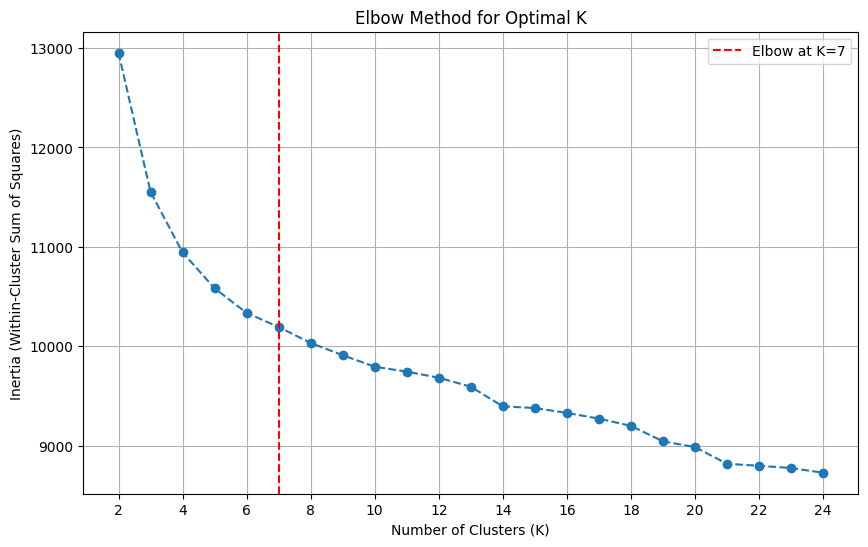

Optimal number of clusters: 7


In [27]:
# Elbow plot for optimal number of clusters
optimal_k = utils.plot_elbow_curve(skill_vectors)
print(f"Optimal number of clusters: {optimal_k}")

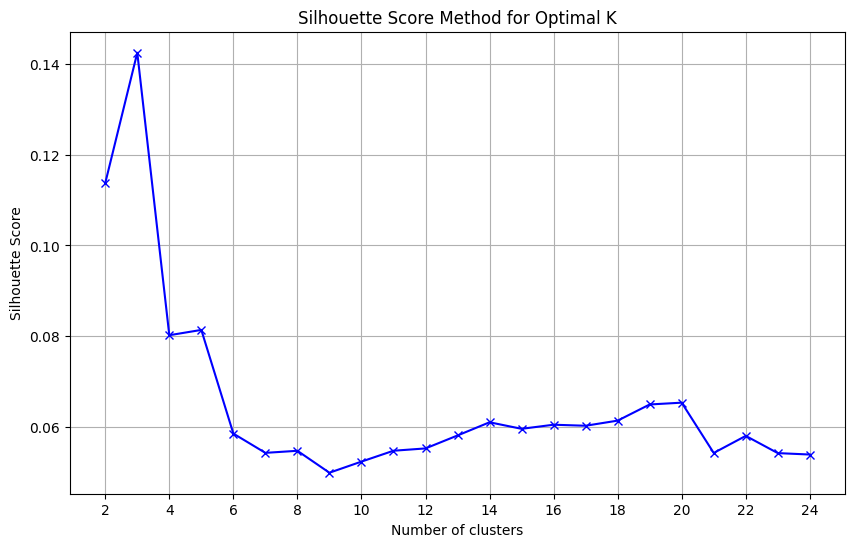

{2: 0.11375995725393295, 3: 0.1425323784351349, 4: 0.08017118275165558, 5: 0.08134263753890991, 6: 0.05845694988965988, 7: 0.05420343950390816, 8: 0.05465909093618393, 9: 0.04981877654790878, 10: 0.05227343365550041, 11: 0.05467178672552109, 12: 0.05518247187137604, 13: 0.05804052948951721, 14: 0.060953106731176376, 15: 0.0595116950571537, 16: 0.06041363254189491, 17: 0.06018814817070961, 18: 0.061319660395383835, 19: 0.064886175096035, 20: 0.0652831569314003, 21: 0.05418356880545616, 22: 0.05794975161552429, 23: 0.05414827913045883, 24: 0.05383334308862686}


In [28]:
# Plot silhouette scores to help determine optimal K for vectors
silhouette_scores = utils.plot_silhouette_scores(skill_vectors)
print(silhouette_scores)

In [29]:
# Perform clustering and get results
cluster_labels, inertia_value, sc_score, skill_to_cluster_id_spacy = utils.perform_kmeans_clustering(skill_vectors, unique_skills_list, K=6)

Inertia for K=6: 10334.2578125
Silhouette Score for K=6: 0.05845694988965988


In [30]:
utils.print_clusters_and_skills(skill_to_cluster_id_spacy, K=6)

Cluster 0:
containerization, containerization technologies
--------------------------------------------------
Cluster 1:
javascript/typescript, react, express.js, azure, multitasking, tableau, power bi, s3, lambda, spark, microservices, rest api, redux, typescript, react.js, typescript/javascript, restful apis, ci/cd pipelines, docker, r, graphql, angular, azure data factory, spring boot, kubernetes, helm charts, shell, fastapi, tensorflow, pytorch, elastic search, terraform, react native, javascript (es6+), styled-components, azure databricks, snowflake, scrum, post-test damage characterization, load cells, thermocouples, transducers, es6+ javascript, figma, microservices architecture, shop drawings, c#, rest, soap, spring, selenium, springboot, kotlin, reactjs, databricks, bigquery, go, webpack, babel, jasmine, flask, expressjs, laravel, vuejs, vue.js, chef, puppet, grafana, .net, scikit-learn, talend, c/c++, gitlab, next.js, tailwind, pyspark, bash, rest apis, material ui, ci/cd, c,

In [31]:
df_clustered_spacy = df_skills.copy()
# df_clustered_spacy['skill_cluster_ids'] = df_clustered_spacy['skills'].apply(map_skills_to_clusters)

df_clustered_spacy['skill_cluster_ids'] = df_clustered_spacy['skills'].apply(
    lambda skills_list: utils.map_skills_to_clusters(skills_list, skill_to_cluster_id_spacy)
)

In [32]:
# Print cluster IDs for each general job classification
classification_clusters = df_clustered_spacy.groupby('general job classification')['skill_cluster_ids'].apply(
    lambda x: set(cluster_id for cluster_list in x for cluster_id in cluster_list if cluster_list)
)

for classification, clusters in classification_clusters.items():
    print(f"General Job Classification: {classification}")
    print(f"Cluster IDs: {sorted(clusters)}")
    print("-" * 50)

General Job Classification: Business Analysis
Cluster IDs: [np.int32(1), np.int32(3), np.int32(4), np.int32(5)]
--------------------------------------------------
General Job Classification: Data & Analytics
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(5)]
--------------------------------------------------
General Job Classification: Project Management
Cluster IDs: [np.int32(1), np.int32(3), np.int32(5)]
--------------------------------------------------
General Job Classification: Software Development / Engineering
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5)]
--------------------------------------------------
General Job Classification: Technical Architecture
Cluster IDs: [np.int32(0), np.int32(5)]
--------------------------------------------------


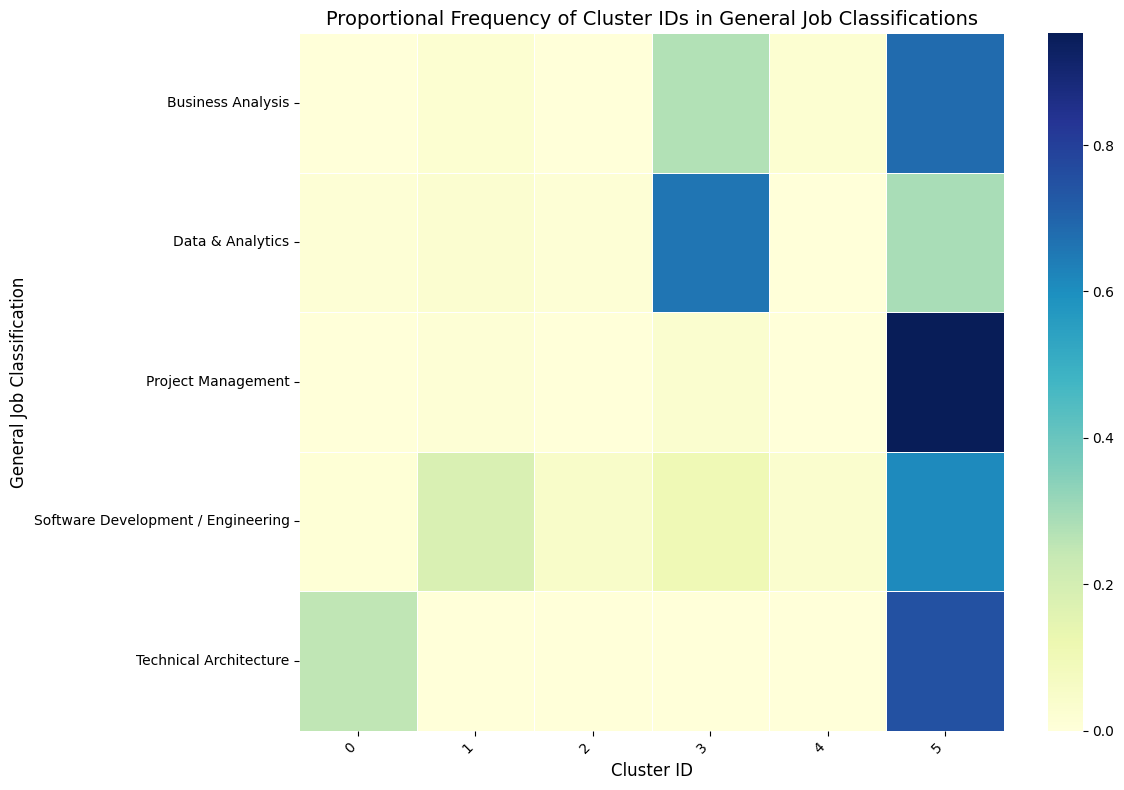

In [33]:
utils.plot_cluster_heatmap(df_clustered_spacy)

In [35]:
pca_df = utils.reduce_dimensionality_pca(skill_vectors, cluster_labels)

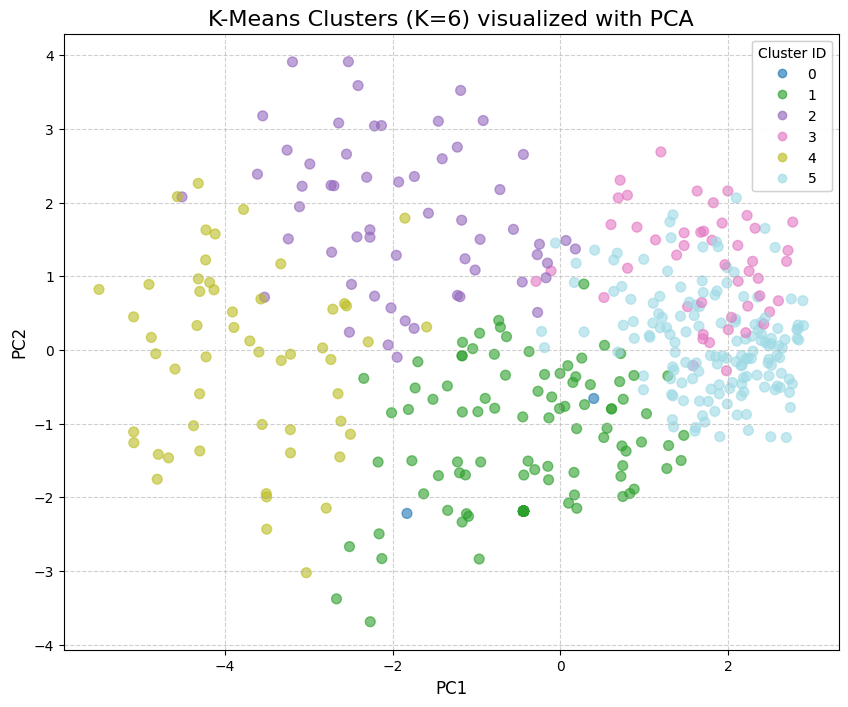

In [36]:
utils.plot_2d_clusters_pca(df_to_plot=pca_df, k_clusters=6)

### Second embedding approach - TF-IDF Vectorization

In [101]:
# Use the already prepared unique_skills_list
print(f"Number of unique skills to vectorize: {len(unique_skills_list)}")

# Vectorize the skills using TF-IDF
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)  # Adjust min_df/max_df as needed
tfidf_matrix = vectorizer.fit_transform(unique_skills_list).toarray()


Number of unique skills to vectorize: 434


Elbow point detected at K = 6


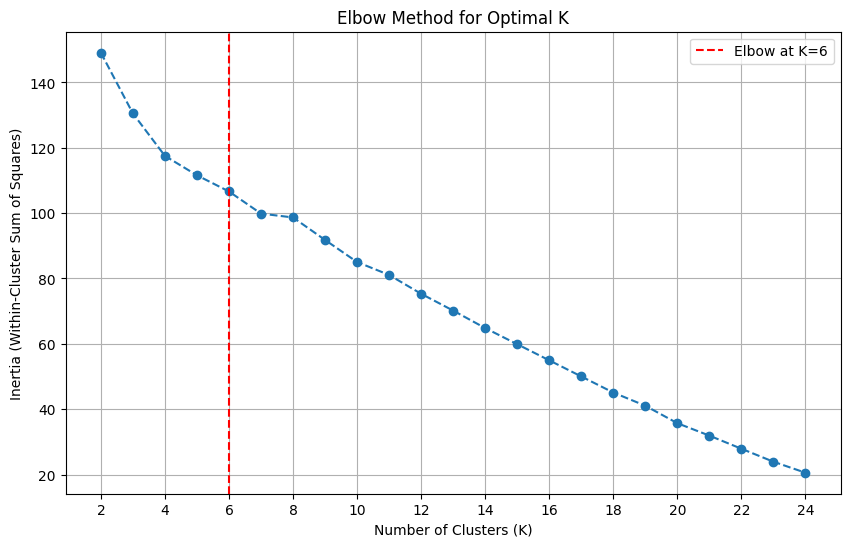

Optimal number of clusters (TF-IDF): 6


In [102]:
# elbow plot for optimal number of clusters
optimal_k_tfidf = utils.plot_elbow_curve(tfidf_matrix)
print(f"Optimal number of clusters (TF-IDF): {optimal_k_tfidf}")

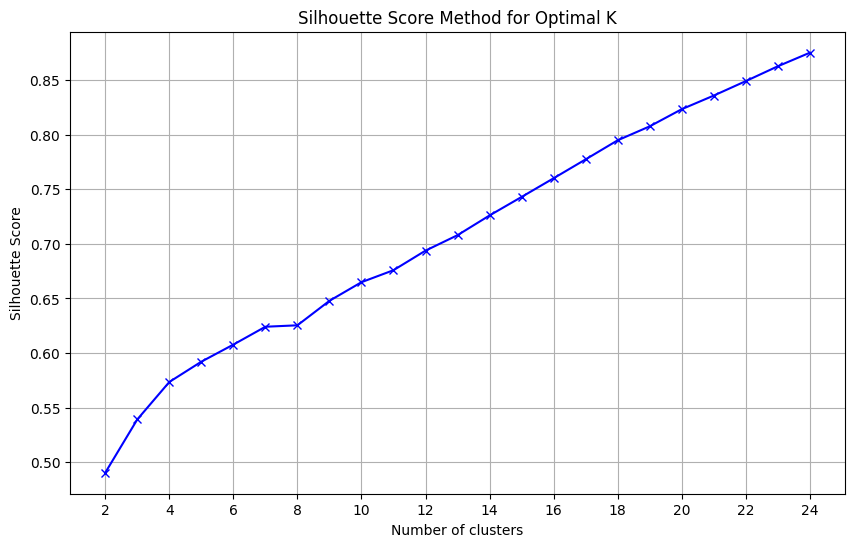

{2: 0.49042339687021547, 3: 0.5392036723744574, 4: 0.5734879286925031, 5: 0.5920810722751012, 6: 0.6077215105928817, 7: 0.6240722895174973, 8: 0.625389594073229, 9: 0.6477946857068303, 10: 0.664853744374939, 11: 0.6758447976257442, 12: 0.6937598993766314, 13: 0.7079024608779055, 14: 0.7259621997947597, 15: 0.7429034915956778, 16: 0.7600116431274506, 17: 0.7772944353567947, 18: 0.794760136645752, 19: 0.8075400061995303, 20: 0.8232349535243333, 21: 0.8357097625445298, 22: 0.8489445347457695, 23: 0.8625228041924735, 24: 0.8749543804350488}


In [39]:
# silhouette plot for optimal number of clusters
silhouette_scores_tfidf = utils.plot_silhouette_scores(tfidf_matrix)
print(silhouette_scores_tfidf)

In [103]:
# perform clustering and get results
cluster_labels_tfidf, inertia_value, sc_score, skill_to_cluster_id_tfidf = utils.perform_kmeans_clustering(tfidf_matrix, unique_skills_list, K=6)

Inertia for K=6: 106.63040506840947
Silhouette Score for K=6: 0.6077215105928817


In [104]:
utils.print_clusters_and_skills(skill_to_cluster_id_tfidf, K=6)

Cluster 0:
javascript/typescript, react, python, relational databases, nosql databases, html5, css3, cloud platforms, aws, azure, google cloud platform, testing, interpersonal skills, organizational skills, multitasking, attention to detail, tableau, power bi, architecture, ec2, s3, lambda, etl, sql, spark, json, security, java, microservices, rest api, web services, redux, typescript, analytics, golang, gcp, typescript/javascript, kafka, postgresql, team collaboration, software implementation, business analysis, communication, problem solving, leadership, quality assurance, spring framework, restful apis, ci/cd pipelines, jira, javascript, php, html, css, git, mysql, apache, docker, analytical skills, statistics, r, cost estimation, scheduling, team leadership, graphql, restful services, angular, critical thinking, written communication, verbal communication, microsoft office suite, spring boot, core java, j2ee, kubernetes, helm charts, azure devops, linux, shell, maven, engineering, 

In [105]:
df_clustered_tfidf = df_skills.copy()
# df_clustered_tfidf['skill_cluster_ids'] = df_clustered_tfidf['skills'].apply(map_skills_to_clusters)

df_clustered_tfidf['skill_cluster_ids'] = df_clustered_tfidf['skills'].apply(
    lambda skills_list: utils.map_skills_to_clusters(skills_list, skill_to_cluster_id_tfidf)
)

In [106]:
# Print cluster IDs for each general job classification
classification_clusters = df_clustered_tfidf.groupby('general job classification')['skill_cluster_ids'].apply(
    lambda x: set(cluster_id for cluster_list in x for cluster_id in cluster_list if cluster_list)
)

for classification, clusters in classification_clusters.items():
    print(f"General Job Classification: {classification}")
    print(f"Cluster IDs: {sorted(clusters)}")
    print("-" * 50)

General Job Classification: Business Analysis
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(3)]
--------------------------------------------------
General Job Classification: Data & Analytics
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(5)]
--------------------------------------------------
General Job Classification: Project Management
Cluster IDs: [np.int32(0), np.int32(1), np.int32(3), np.int32(5)]
--------------------------------------------------
General Job Classification: Software Development / Engineering
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5)]
--------------------------------------------------
General Job Classification: Technical Architecture
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2)]
--------------------------------------------------


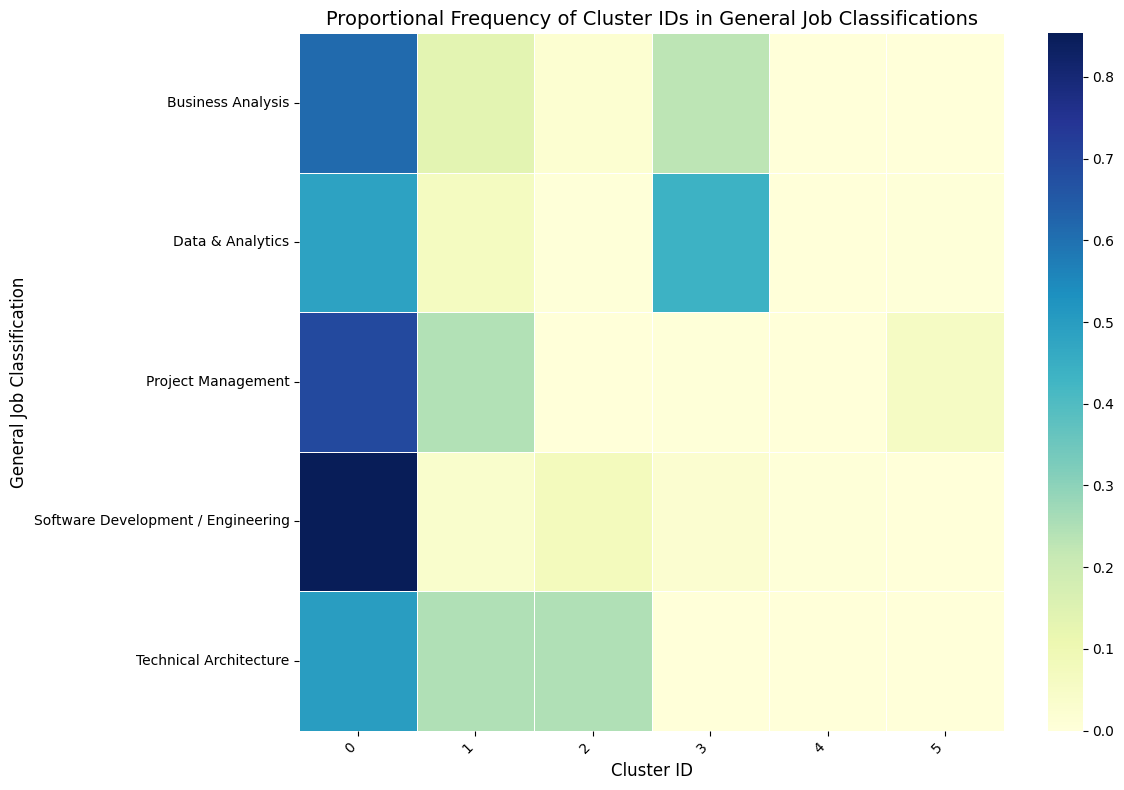

In [44]:
utils.plot_cluster_heatmap(df_clustered_tfidf) # TODO: CLUSTER THE CLUSTER !!! CLUSTER 0 CLUSTER

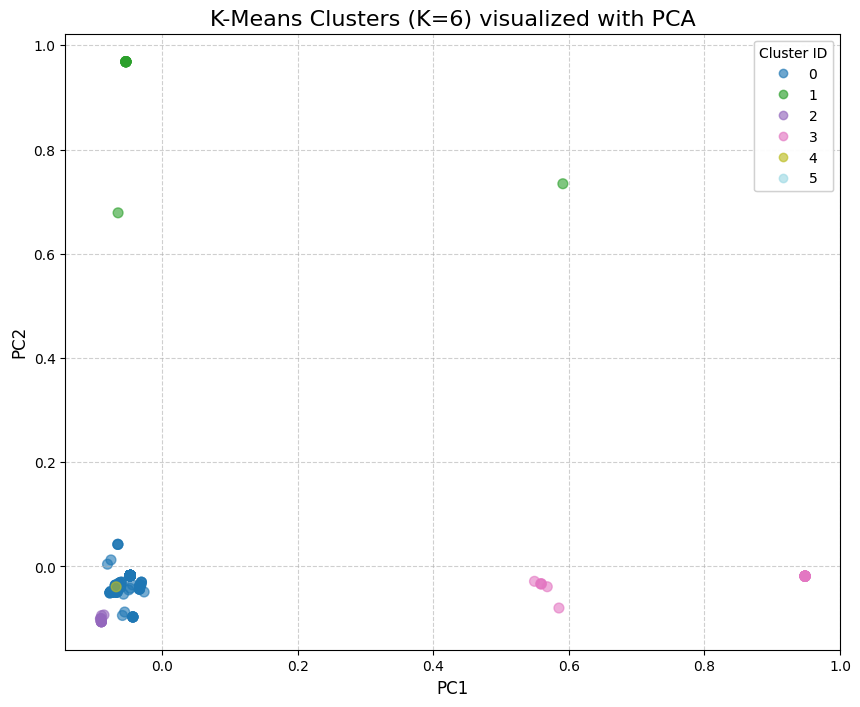

In [45]:
pca_df = utils.reduce_dimensionality_pca(tfidf_matrix, cluster_labels_tfidf)
utils.plot_2d_clusters_pca(df_to_plot=pca_df, k_clusters=6)


Starting t-SNE reduction. This may take a moment...
t-SNE reduction complete.


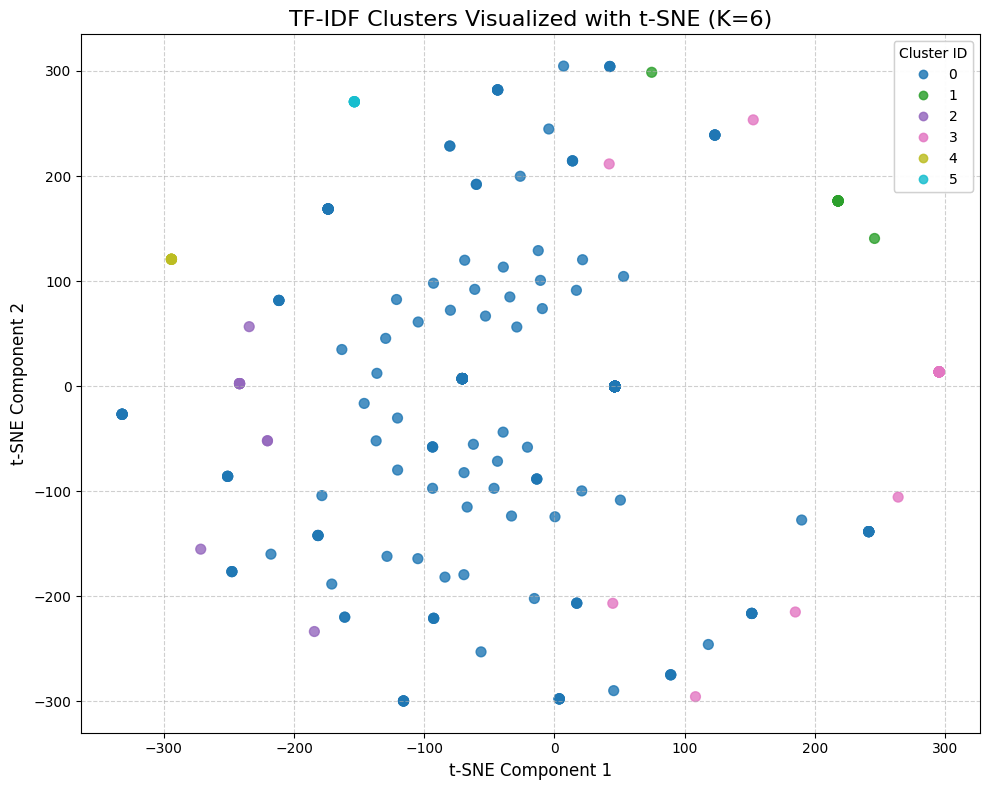


Visualization complete. The t-SNE plot should show clearer separation between the 6 clusters if the Silhouette Score was accurate.


In [47]:
print("\nStarting t-SNE reduction. This may take a moment...")

tsne = TSNE(
    n_components=2,
    perplexity=30,  # Common starting value
    # n_iter=5000,    # High iterations for better convergence
    random_state=42,
    learning_rate='auto', # Recommended for newer versions
    init='pca'      # Initialize with PCA for faster results
)

# Perform the reduction on the high-dimensional TF-IDF data
tfidf_vectors_2d_tsne = tsne.fit_transform(tfidf_matrix)
print("t-SNE reduction complete.")

# --- VISUALIZATION ---

# Create a DataFrame for easy plotting
tsne_df = pd.DataFrame(tfidf_vectors_2d_tsne, columns=['TSNE_1', 'TSNE_2'])
tsne_df['Cluster'] = cluster_labels_tfidf  # Add your cluster labels

# Scatter Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    tsne_df['TSNE_1'],
    tsne_df['TSNE_2'],
    c=tsne_df['Cluster'],
    cmap='tab10',  # Use a colormap with distinct colors for the 7 clusters
    s=50,
    alpha=0.8
)

# Add title and labels
plt.title('TF-IDF Clusters Visualized with t-SNE (K=6)', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)

# Add a legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster ID", loc="best")
plt.gca().add_artist(legend1)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\nVisualization complete. The t-SNE plot should show clearer separation between the 6 clusters if the Silhouette Score was accurate.")


In [ ]:
# df_clustered_tfidf.to_csv('restore_code_version.csv')

### GloVe embedding

In [48]:
# Load GloVe embeddings
embeddings = GloVe(name='6B', dim=100)

# Set the maximum sentence length and embedding dimension
max_length = 100
embedding_dim = 100

# Define a function to convert a sentence to a fixed-size vector using GloVe embeddings
def sentence_embedding(sentence):
    """
    Converts a sentence to a fixed-size vector using GloVe embeddings.

    Args:
        sentence (str): The input sentence.

    Returns:
        np.ndarray: A flattened vector representation of the sentence.
    """
    words = sentence.split()
    num_words = min(len(words), max_length)
    embedding_sentence = np.zeros((max_length, embedding_dim))
    
    for i in range(num_words):
        word = words[i]
        if word in embeddings.stoi:  # Check if the word exists in GloVe vocabulary
            embedding_sentence[i] = embeddings.vectors[embeddings.stoi[word]]
            
    return embedding_sentence.flatten()

# Apply the sentence embedding function to the unique skills list
unique_skills_df = pd.DataFrame({'skill': unique_skills_list})  # Create a DataFrame for the skills
unique_skills_df['encode_glove'] = unique_skills_df['skill'].apply(sentence_embedding)

# Stack the embeddings into a matrix for clustering
X_glove = np.vstack(unique_skills_df['encode_glove'])

print(f"Shape of GloVe embeddings matrix: {X_glove.shape}")

Shape of GloVe embeddings matrix: (434, 10000)


Elbow point detected at K = 4


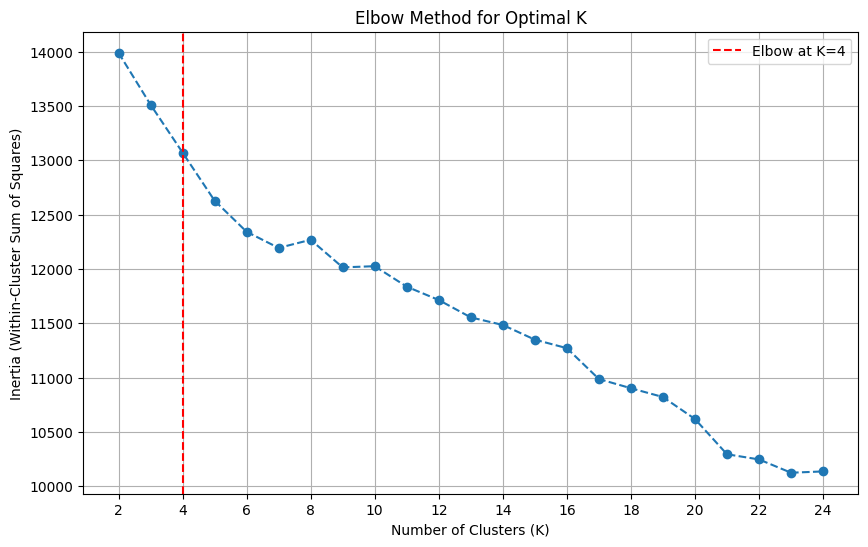

4

In [49]:
utils.plot_elbow_curve(X_glove)

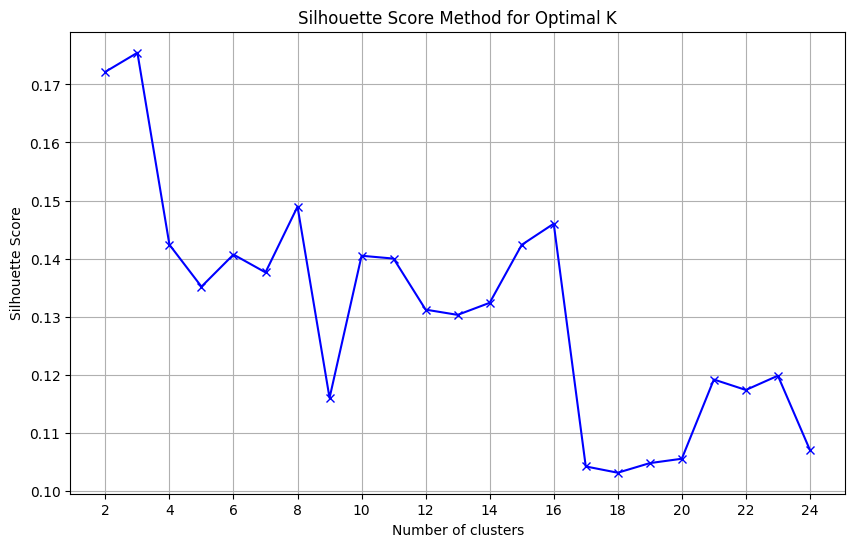

{2: 0.17216859289328693,
 3: 0.1754515597488056,
 4: 0.1424009337297482,
 5: 0.13518176729619183,
 6: 0.1407063242473517,
 7: 0.13763585294356062,
 8: 0.14896077993210416,
 9: 0.11602538353442207,
 10: 0.14049986347843843,
 11: 0.14001216149684587,
 12: 0.1312247721804152,
 13: 0.1303241500028172,
 14: 0.13239957225429974,
 15: 0.14237795926863311,
 16: 0.14601869913841717,
 17: 0.1042310146205997,
 18: 0.10315032227494889,
 19: 0.10480483709246013,
 20: 0.1055569400270721,
 21: 0.11919717381826461,
 22: 0.11739622918746168,
 23: 0.11985199857836114,
 24: 0.10706358072370195}

In [50]:
utils.plot_silhouette_scores(X_glove)

In [51]:
# Perform clustering and get results
cluster_labels_glove, inertia_value, sc_score, skill_to_cluster_id_glove = utils.perform_kmeans_clustering(X_glove, unique_skills_list, K=4)

Inertia for K=4: 13070.964632985837
Silhouette Score for K=4: 0.1424009337297482


In [52]:
utils.print_clusters_and_skills(skill_to_cluster_id_glove, K=4)

Cluster 0:
javascript/typescript, node.js, python, express.js, relational databases, nosql databases, html5, css3, aws, azure, multitasking, tableau, ec2, s3, lambda, etl, sql, json, java, microservices, redux, typescript, react.js, analytics, golang, gcp, typescript/javascript, kafka, postgresql, restful apis, ci/cd pipelines, jira, javascript, php, html, css, git, mysql, apache, docker, graphql, angular, j2ee, kubernetes, azure devops, linux, maven, fastapi, tensorflow, pytorch, pl/sql, excel, jenkins, terraform, javascript (es6+), flexbox, styled-components, azure databricks, snowflake, sql queries, automation, scrum, agile, post-test damage characterization, thermocouples, transducers, es6+ javascript, c++, hl7, figma, sql server, estimating, budgeting, containerization, rabbitmq, redis, c#, oracle, nosql, soap, mongodb, elasticsearch, scala, selenium, springboot, kotlin, reactjs, gradle, junit, nginx, scss, databricks, hadoop, bigquery, problem-solving, troubleshooting, solidworks

In [53]:
df_clustered_glove = df_skills.copy()
# df_clustered_glove['skill_cluster_ids'] = df_clustered_glove['skills'].apply(map_skills_to_clusters)
df_clustered_glove['skill_cluster_ids'] = df_clustered_glove['skills'].apply(
    lambda skills_list: utils.map_skills_to_clusters(skills_list, skill_to_cluster_id_glove)
)

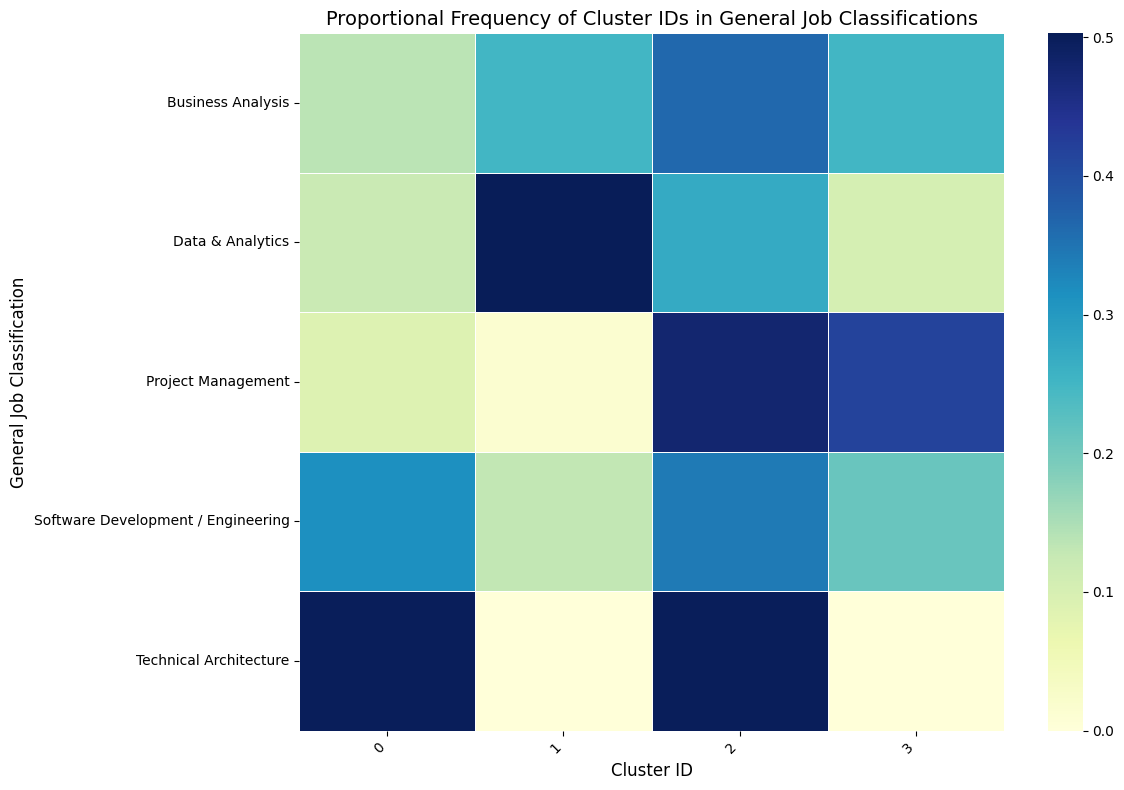

In [54]:
utils.plot_cluster_heatmap(df_clustered_glove)

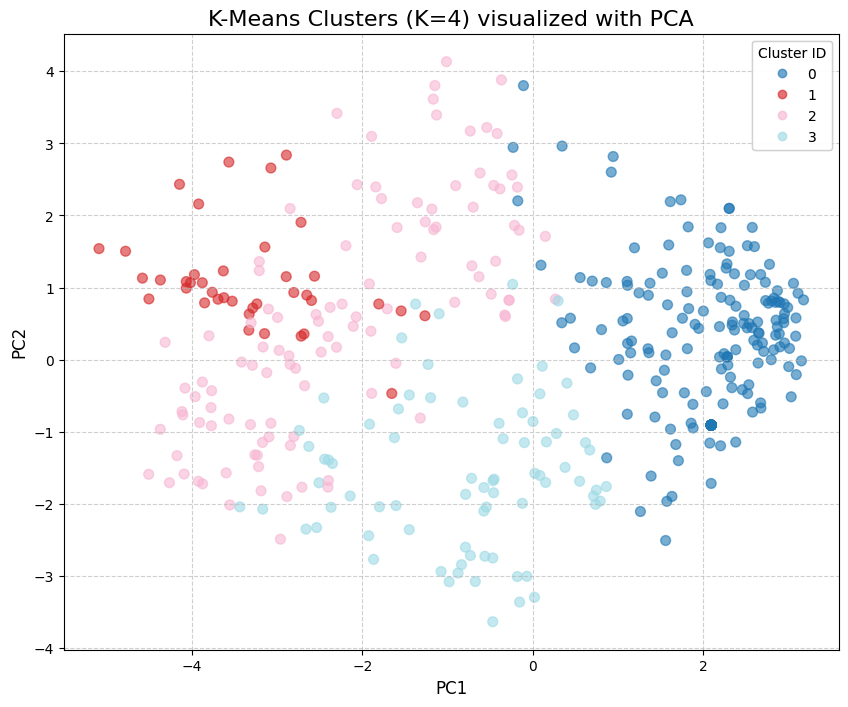

In [55]:
pca_df = utils.reduce_dimensionality_pca(X_glove, cluster_labels_glove)
utils.plot_2d_clusters_pca(df_to_plot=pca_df, k_clusters=4)

### BERT embedding

In [56]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Define a function to create BERT embeddings for a given skill
def bert_embedding(skill):
    """
    Converts a skill (sentence) into a BERT embedding.

    Args:
        skill (str): The input skill.

    Returns:
        np.ndarray: A vector representation of the skill.
    """
    # Tokenize the skill and convert to input IDs
    inputs = tokenizer(skill, return_tensors='pt', padding=True, truncation=True, max_length=50)
    
    # Get the BERT embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Use the [CLS] token embedding as the sentence embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0).numpy()
    
    return cls_embedding

# Apply the BERT embedding function to the unique skills list
unique_skills_df = pd.DataFrame({'skill': unique_skills_list})  # Create a DataFrame for the skills
unique_skills_df['bert_embedding'] = unique_skills_df['skill'].apply(bert_embedding)

# Stack the embeddings into a matrix for clustering
X_bert = np.vstack(unique_skills_df['bert_embedding'])

print(f"Shape of BERT embeddings matrix: {X_bert.shape}")

Shape of BERT embeddings matrix: (434, 768)


Elbow point detected at K = 5


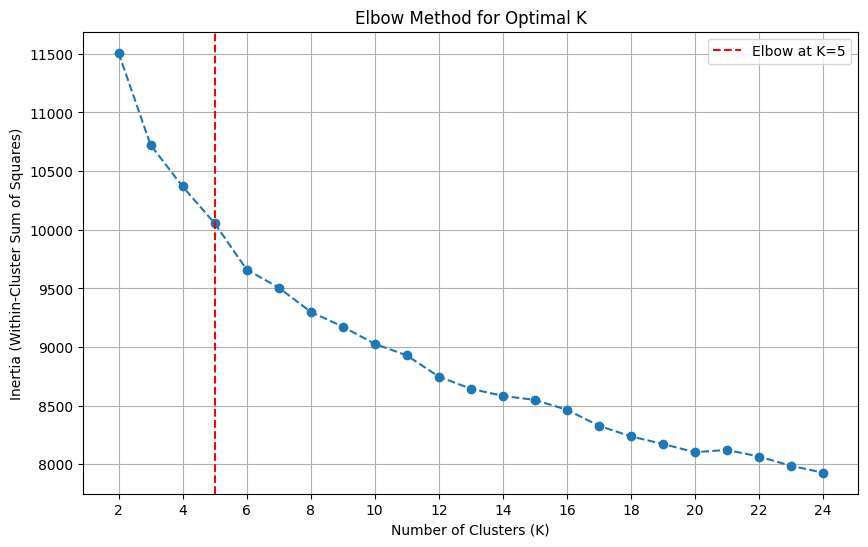

5

In [57]:
utils.plot_elbow_curve(X_bert)

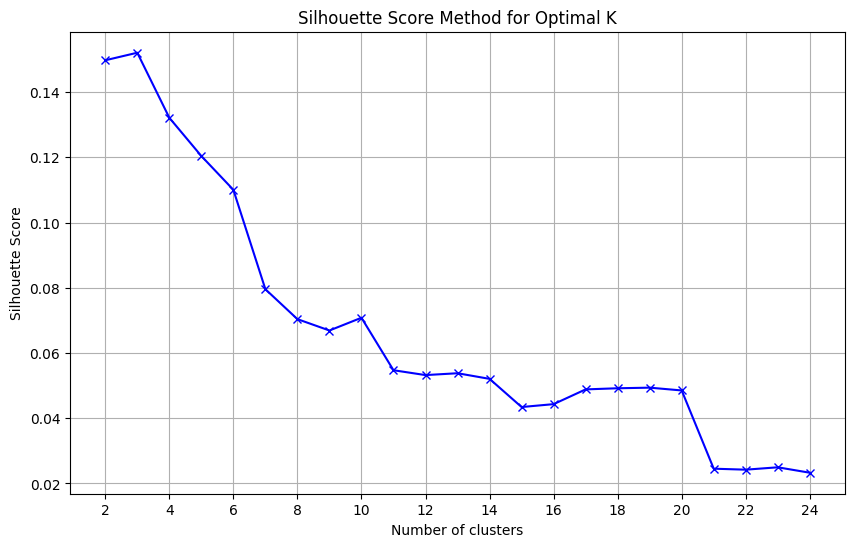

{2: 0.14974434673786163,
 3: 0.15206390619277954,
 4: 0.13212625682353973,
 5: 0.12039360404014587,
 6: 0.11003005504608154,
 7: 0.07954540103673935,
 8: 0.07036961615085602,
 9: 0.06688293069601059,
 10: 0.07079324126243591,
 11: 0.05470120161771774,
 12: 0.05321087688207626,
 13: 0.05377812683582306,
 14: 0.0520545057952404,
 15: 0.04341600462794304,
 16: 0.04429987818002701,
 17: 0.0488254651427269,
 18: 0.049170877784490585,
 19: 0.04935585707426071,
 20: 0.04850105568766594,
 21: 0.024506552144885063,
 22: 0.02420850843191147,
 23: 0.02493416704237461,
 24: 0.023272182792425156}

In [58]:
utils.plot_silhouette_scores(X_bert)

In [59]:
# Perform clustering and get results
cluster_labels_bert, inertia_value, sc_score, skill_to_cluster_id_bert = utils.perform_kmeans_clustering(X_bert, unique_skills_list, K=5)

Inertia for K=5: 10055.7646484375
Silhouette Score for K=5: 0.12039360404014587


In [60]:
utils.print_clusters_and_skills(skill_to_cluster_id_bert, K=5)

Cluster 0:
relational databases, nosql databases, cloud platforms, multitasking, data warehousing, microservices, restful apis, ci/cd pipelines, data analytics, agile development methodologies, shell scripting, data visualization tools, data pipelines, agile environment, database management, sql queries, data acquisitions systems, transducers, 3d parametric design software, agile methodology, configuration management, microservices architecture, data architecture, data modeling, big data technologies, containerization, database design, cloud technologies, data visualization, machine learning, databricks, etl processes, distributed systems, data preprocessing, containerization technologies, data management, full-stack development, data mining, neural networks, pattern recognition, statistical techniques, predictive modeling, cloud computing, agile methodologies, agile development, reporting packages, wordpress development, database administration, cloud native applications, rdbms, apis,

In [61]:
df_clustered_bert = df_skills.copy()
# df_clustered_bert['skill_cluster_ids'] = df_clustered_bert['skills'].apply(map_skills_to_clusters)
df_clustered_bert['skill_cluster_ids'] = df_clustered_bert['skills'].apply(
    lambda skills_list: utils.map_skills_to_clusters(skills_list, skill_to_cluster_id_bert)
)

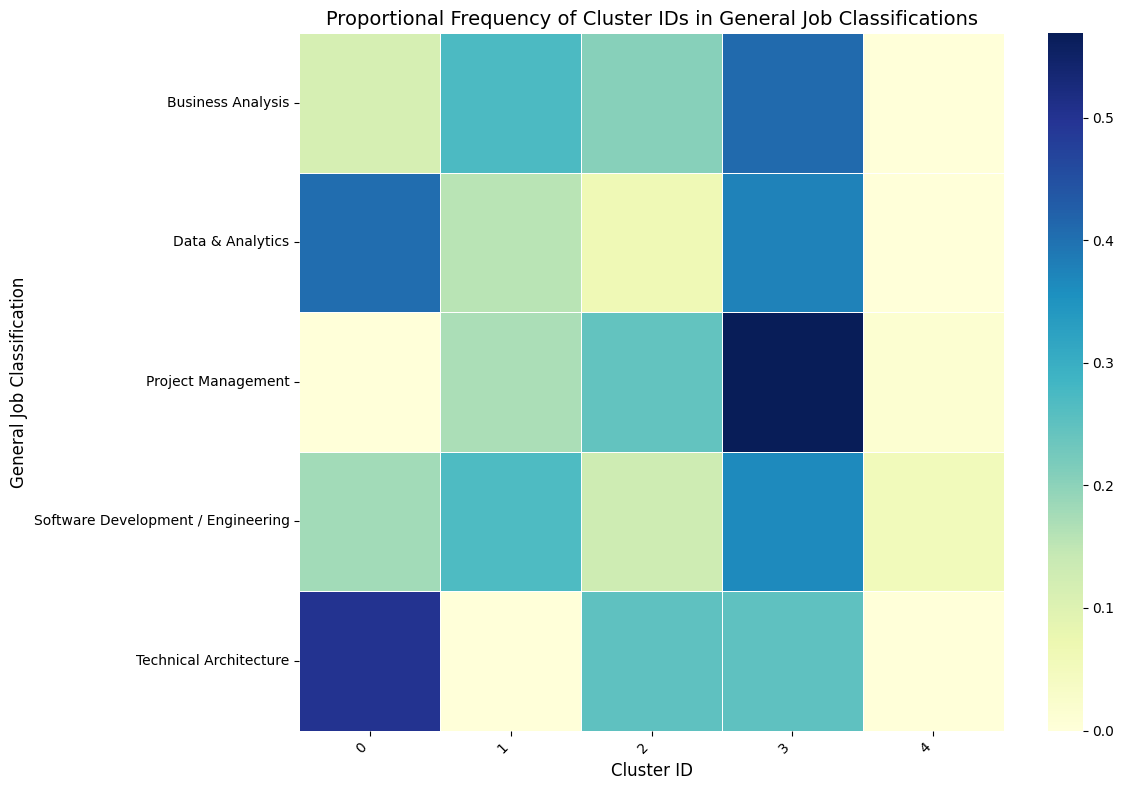

In [62]:
utils.plot_cluster_heatmap(df_clustered_bert)

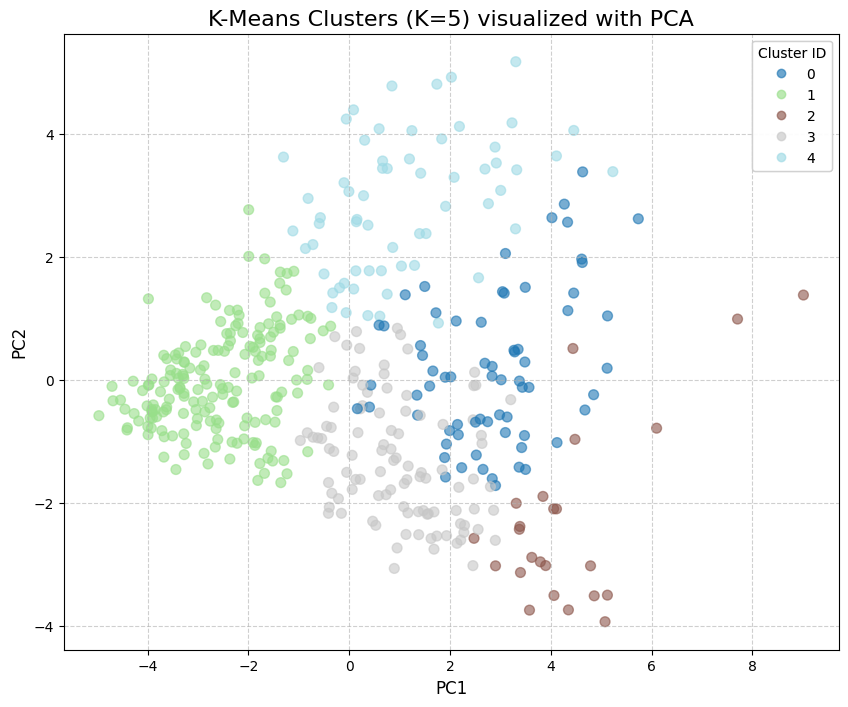

In [63]:
pca_df = utils.reduce_dimensionality_pca(X_bert, cluster_labels_bert) # TODO ile zmiennosci wyjasnia PCA - ile variability wyjasnia PCA
utils.plot_2d_clusters_pca(df_to_plot=pca_df, k_clusters=5)

### Creating features using one hot encoding for our model after embedding and clustering

We will be using the resulting dataframe from clustering performed after tf idf word embedding.

In [107]:
most_common_skills = utils.most_common_skills_per_cluster(df_clustered_tfidf, skill_to_cluster_id_tfidf, top_n=10)
for cluster_id, skills in most_common_skills.items():
    print(f"Cluster {cluster_id}: {', '.join(skills)}")
    print("-" * 50)

Cluster 0: python, sql, javascript, c#, html, c++, java, react, typescript, aws
--------------------------------------------------
Cluster 4: node.js, react.js, vue.js, next.js, express.js, js
--------------------------------------------------
Cluster 5: quality control, control, cost control, version control, document control
--------------------------------------------------
Cluster 2: software development, full stack development, backend development, front-end development, agile development methodologies, test case development, full-stack development, agile development, back-end development, wordpress development
--------------------------------------------------
Cluster 3: data analysis, data visualization, data modeling, data warehousing, data analytics, data governance, big data, data structures, data architecture, data engineering
--------------------------------------------------
Cluster 1: project management, construction management, database management, risk management, team 

In [108]:
cluster_features = df_clustered_tfidf['skill_cluster_ids'].apply(lambda ids: utils.create_cluster_features(ids, K=6))

Generate Count Features: Use one-hot encoding or counting to create a feature for each cluster category. This is the final, most valuable feature set for your prediction model.

In [109]:
cluster_counts = df_clustered_tfidf.explode('skill_cluster_ids').groupby(level=0)['skill_cluster_ids'].value_counts()
cluster_features = cluster_counts.unstack(fill_value=0)
cluster_features = cluster_features.reindex(df_clustered_tfidf.index, fill_value=0) # Ensure the index matches
df_clustered_tfidf = df_clustered_tfidf.join(cluster_features)

## Understanding sentiment in job descriptions

We will use VADER Analysis  (Valence Aware Dictionary and sEntiment Reasoner)

In [ ]:
!pip install nltk

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/juliabarsow/nltk_data...


True

In [110]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

df_clustered_tfidf['sentiment'] = df_clustered_tfidf['description'].apply(get_sentiment)

In [111]:
# scaling sentiment scores to introduce more variablity
df_clustered_tfidf['scaled_sentiment'] = -np.log10(1 - df_clustered_tfidf['sentiment'])

In [112]:
df_clustered_tfidf['scaled_sentiment'].describe()

count    739.000000
mean       1.902124
std        0.790365
min       -0.000000
25%        1.447332
50%        1.856985
75%        2.568636
max        3.698970
Name: scaled_sentiment, dtype: float64

In [113]:
df_clustered_tfidf.head()

,job_id,title,description,general job classification,skills,formal_requirements,skill_cluster_ids,0,1,2,3,4,5,sentiment,scaled_sentiment
0,2234533717,Full Stack Engineer,"Location: Remote\nCompany Overview:SkillFit, a...",Software Development / Engineering,"[full-stack web development, JavaScript/TypeSc...",[3+ years of professional experience in softwa...,"[0, 0, 5, 0]",3,0,0,0,0,1,0.9989,2.958607
1,2269442456,Computer Scientist,Are you passionate about developing cutting-ed...,Software Development / Engineering,"[software development, deep space communicatio...",[Bachelor's degree in Computer Science or rela...,[2],0,0,1,0,0,0,0.9853,1.832683
2,2314566469,Front end specialist,Regional law firm looking for a candidate with...,Software Development / Engineering,"[phone sales, customer service, interpersonal ...","[superior phone sales experience, passion for ...","[0, 0, 0, 0]",4,0,0,0,0,0,0.9665,1.474955
3,2735151240,Intern- Business Analytics,Summer Internshipadidas & Carhartt kids Divisi...,Data & Analytics,"[data analysis, modeling, visualization, Micro...","[MBA program with a focus in data analytics, P...",[3],0,0,0,1,0,0,0.9965,2.455932
4,3045980831,Project Engineer,JOB DESCRIPTION:The Project Engineer assists t...,Project Management,"[Construction/Civil Engineering, Architecture,...",[Bachelor's degree in Construction/Civil Engin...,[],0,0,0,0,0,0,0.8779,0.913284


## Job Posting Success Prediction

In [114]:
# Columns from original dataset to keep for prediction
columns_to_keep = [
    'formatted_work_type',
    'views',
    'job_id'
]

In [115]:
# columns to keep from clustered dataset
clustered_columns_to_keep = [
    'general job classification',
    # 'scaled_sentiment',
    'description',
    'job_id'
] + list(range(6))  # Add cluster count columns (0 to K)

In [116]:
# Merge selected clustered word embeddings dataframe with selected columns from original data
final_df = df_clustered_tfidf[clustered_columns_to_keep].merge(data[columns_to_keep], on='job_id', how='left')

In [117]:
# rename numeric cluster columns to have a prefix
final_df.rename(columns={i: f'cluster_{i}' for i in range(6)}, inplace=True)

In [118]:
# drop rows where viewes is missing
final_df = final_df.dropna(subset=['views'])

In [119]:
final_df.head()

,general job classification,description,job_id,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,formatted_work_type,views
0,Software Development / Engineering,"Location: Remote\nCompany Overview:SkillFit, a...",2234533717,3,0,0,0,0,1,Full-time,21.0
2,Software Development / Engineering,Regional law firm looking for a candidate with...,2314566469,4,0,0,0,0,0,Full-time,3.0
3,Data & Analytics,Summer Internshipadidas & Carhartt kids Divisi...,2735151240,0,0,0,1,0,0,Temporary,5.0
4,Project Management,JOB DESCRIPTION:The Project Engineer assists t...,3045980831,0,0,0,0,0,0,Full-time,4.0
5,Data & Analytics,Request: Data ArchitectLocation: San Francisco...,3245063922,0,0,0,0,0,0,Contract,7.0


In [120]:
# Define the labels for your bins - we predict is job posting is successful or not
bin_labels = ['Bin 1: Lowest 25%', 'Bin 2: Low-Medium (25-50%)', 'Bin 3: Medium-High (50-75%)', 'Bin 4: Highest 25%']

# Use pd.qcut to create 4 equal-frequency bins
# 'q=4' specifies 4 bins (quartiles)
final_df['views_bin'] = pd.qcut(
    x=final_df['views'],
    q=4,
    labels=bin_labels,
    duplicates='drop'  # Handles cases where quartiles are identical
)

# Check the distribution
print("Bin Boundaries (The Quantiles):")
print(final_df['views_bin'].cat.codes.value_counts())
print("\nViews Bins Distribution:")
print(final_df['views_bin'].value_counts(normalize=True))

Bin Boundaries (The Quantiles):
0    239
3    179
2    173
1    134
Name: count, dtype: int64

Views Bins Distribution:
views_bin
Bin 1: Lowest 25%              0.329655
Bin 4: Highest 25%             0.246897
Bin 3: Medium-High (50-75%)    0.238621
Bin 2: Low-Medium (25-50%)     0.184828
Name: proportion, dtype: float64


In [121]:
from sklearn.model_selection import train_test_split

cluster_cols = [f'cluster_{i}' for i in range(0, 6)]

X = final_df[cluster_cols + [ 'formatted_work_type', 'general job classification']]
y = final_df['views_bin']

# Use stratify=y to maintain class proportions in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    random_state=0,
    train_size=0.8,
    stratify=y
)

print('Size of training set = %d and test set = %d' % (y_train.size, y_test.size))

Size of training set = 580 and test set = 145


In [122]:
# One-hot encode categorical features
col_dummny = ['formatted_work_type',  'general job classification']
numeric_cols = [col for col in X.columns if col not in col_dummny]
# Initialize the OneHotEncoder within a ColumnTransformer
# The 'handle_unknown="ignore"' tells the encoder to ignore (set to 0) 
# any categories in the test set that were not seen in the training set.
# 'drop='first'' mimics the behavior of drop_first=True in pd.get_dummies
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', 
         OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), 
         col_dummny),
         ('scaler',  MinMaxScaler(), numeric_cols)
    ],
    remainder='passthrough' # Keep other columns as they are
)

# FIT the preprocessor ONLY on the training data
preprocessor.fit(X_train)

# TRANSFORM both the training and test data
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Convert the resulting NumPy arrays back to DataFrames for modeling, 
# ensuring consistent column names.
feature_names = preprocessor.get_feature_names_out()

# Create DataFrames with the new column names
X_train = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)
X_test = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)

/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [408]:
feature_names

array(['onehot__formatted_work_type_Full-time',
       'onehot__formatted_work_type_Internship',
       'onehot__formatted_work_type_Other',
       'onehot__formatted_work_type_Part-time',
       'onehot__formatted_work_type_Temporary',
       'onehot__general job classification_Data & Analytics',
       'onehot__general job classification_Project Management',
       'onehot__general job classification_Software Development / Engineering',
       'onehot__general job classification_Technical Architecture',
       'scaler__cluster_0', 'scaler__cluster_1', 'scaler__cluster_2',
       'scaler__cluster_3', 'scaler__cluster_4', 'scaler__cluster_5',
       'scaler__cluster_6'], dtype=object)

### Naive Bayes Classifier

In [123]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Naive Bayes classifier
nb_model = GaussianNB()

# Fit the model on the training data
nb_model.fit(X_train, y_train)

# Make predictions on training and test data
y_train_pred = nb_model.predict(X_train)
y_test_pred = nb_model.predict(X_test)

# Training performance
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

# Test performance
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix for test set
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Training Accuracy: 0.3466
Training Classification Report:
                             precision    recall  f1-score   support

          Bin 1: Lowest 25%       0.34      0.98      0.50       191
 Bin 2: Low-Medium (25-50%)       0.33      0.02      0.04       107
Bin 3: Medium-High (50-75%)       1.00      0.01      0.01       139
         Bin 4: Highest 25%       0.58      0.08      0.14       143

                   accuracy                           0.35       580
                  macro avg       0.56      0.27      0.17       580
               weighted avg       0.56      0.35      0.21       580

Test Accuracy: 0.3379
Test Classification Report:
                             precision    recall  f1-score   support

          Bin 1: Lowest 25%       0.34      0.98      0.51        48
 Bin 2: Low-Medium (25-50%)       0.00      0.00      0.00        27
Bin 3: Medium-High (50-75%)       0.00      0.00      0.00        34
         Bin 4: Highest 25%       0.33      0.06      0.10  

/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa

### Random Forest Classifier

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Grid of parameters to choose from
parameters = {
    "max_depth": [5, 10, 15, 20, 30, 40, None],
    "max_leaf_nodes": [None, 50, 100, 200],
    "min_samples_split": [2, 10, 30],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Run the grid search
grid_obj = GridSearchCV(rf_model, parameters, cv=5,scoring='f1_weighted',n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_model = grid_obj.best_estimator_

# Train the Model
print("Training Random Forest Classifier...")
rf_model.fit(X_train, y_train)
print("Training Complete.")

# print parameters of rf model
print("Best parameters found:", grid_obj.best_params_)
print("Best cross-validation score:", grid_obj.best_score_)
print("Best estimator:", grid_obj.best_estimator_)

Training Random Forest Classifier...
Training Complete.
Best parameters found: {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': None, 'min_samples_split': 10}
Best cross-validation score: 0.3209347338073418
Best estimator: RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=10, random_state=42)


<Axes: >

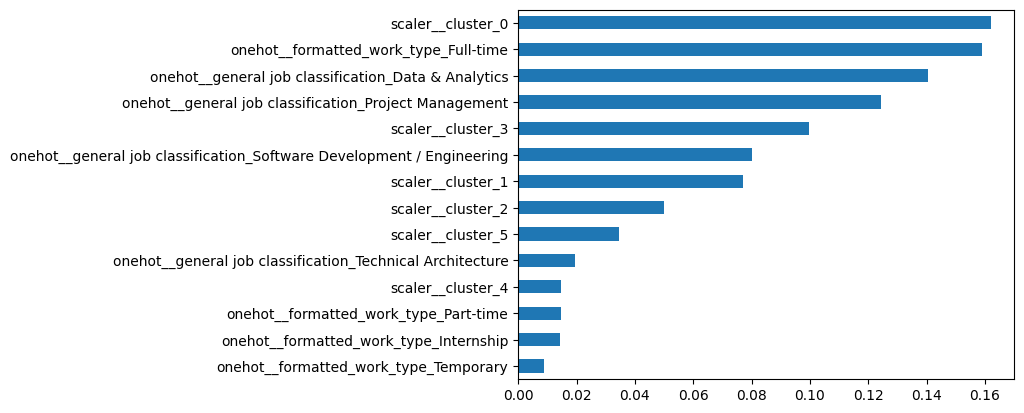

In [125]:
feat_importances = pd.Series(rf_model.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh')

In [126]:
# Make Predictions on the Test Set
y_pred = rf_model.predict(X_test)

# Calculate Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nOverall Test Accuracy: {accuracy:.4f}\n")

# Print the Classification Report
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Print the Confusion Matrix
# This shows exactly how many times the model confused one bin for another.
# Rows are the TRUE bins; Columns are the PREDICTED bins.
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))


Overall Test Accuracy: 0.3241

--- Classification Report ---
                             precision    recall  f1-score   support

          Bin 1: Lowest 25%       0.46      0.33      0.39        48
 Bin 2: Low-Medium (25-50%)       0.12      0.19      0.15        27
Bin 3: Medium-High (50-75%)       0.00      0.00      0.00        34
         Bin 4: Highest 25%       0.40      0.72      0.51        36

                   accuracy                           0.32       145
                  macro avg       0.25      0.31      0.26       145
               weighted avg       0.27      0.32      0.28       145


--- Confusion Matrix ---
[[16 22  0 10]
 [ 7  5  3 12]
 [ 9  8  0 17]
 [ 3  5  2 26]]


### SVM

In [127]:
from sklearn.metrics import mean_squared_error
svm_model = SVC(random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'], 
    'gamma': ['scale', 'auto']      
}

grid = GridSearchCV(svm_model, param_grid, scoring='f1_macro', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# Set the best combination of parameters
svm_model = grid.best_estimator_

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

# Train the Model
print("Training SVM...")
svm_model.fit(X_train, y_train)
print("Training Complete.")

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.26938805827971024
Training SVM...
Training Complete.


In [128]:
# Train results
y_pred_train = svm_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train)

print(f"\nOverall Train Accuracy: {accuracy:.4f}\n")
print(classification_report(y_train, y_pred_train))
print(confusion_matrix(y_train, y_pred_train))

# Test results
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nOverall Test Accuracy: {accuracy:.4f}\n")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Overall Train Accuracy: 0.4224

                             precision    recall  f1-score   support

          Bin 1: Lowest 25%       0.42      0.69      0.52       191
 Bin 2: Low-Medium (25-50%)       1.00      0.03      0.05       107
Bin 3: Medium-High (50-75%)       0.55      0.13      0.21       139
         Bin 4: Highest 25%       0.40      0.65      0.50       143

                   accuracy                           0.42       580
                  macro avg       0.59      0.37      0.32       580
               weighted avg       0.55      0.42      0.35       580

[[131   0   6  54]
 [ 71   3   5  28]
 [ 64   0  18  57]
 [ 46   0   4  93]]

Overall Test Accuracy: 0.4621

                             precision    recall  f1-score   support

          Bin 1: Lowest 25%       0.51      0.77      0.61        48
 Bin 2: Low-Medium (25-50%)       0.00      0.00      0.00        27
Bin 3: Medium-High (50-75%)       0.33      0.06      0.10        34
         Bin 4: Highest 25

/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa

### Logistic Regression and GLM

In [129]:
multi_class='multinomial'
solver='lbfgs'  # or 'saga' for large datasets

# Pipeline for GLM
pipeline = Pipeline([
    ('glm', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        fit_intercept=True
    ))
])


pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_prob_train = pipeline.predict_proba(X_train)  # <-- class probabilities!
accuracy_train = accuracy_score(y_train, y_pred_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)  # <-- class probabilities!
accuracy = accuracy_score(y_test, y_pred)

print(f"\nOverall Train Accuracy: {accuracy_train:.4f}\n")
print("Classification report:")
print(classification_report(y_train, y_pred_train))


print(f"\nOverall Test Accuracy: {accuracy:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred))



Overall Train Accuracy: 0.3879

Classification report:
                             precision    recall  f1-score   support

          Bin 1: Lowest 25%       0.39      0.70      0.50       191
 Bin 2: Low-Medium (25-50%)       0.00      0.00      0.00       107
Bin 3: Medium-High (50-75%)       0.17      0.01      0.01       139
         Bin 4: Highest 25%       0.39      0.63      0.48       143

                   accuracy                           0.39       580
                  macro avg       0.24      0.33      0.25       580
               weighted avg       0.26      0.39      0.29       580


Overall Test Accuracy: 0.4276

Classification report:
                             precision    recall  f1-score   support

          Bin 1: Lowest 25%       0.46      0.77      0.58        48
 Bin 2: Low-Medium (25-50%)       0.00      0.00      0.00        27
Bin 3: Medium-High (50-75%)       0.00      0.00      0.00        34
         Bin 4: Highest 25%       0.40      0.69      0.5

/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter

In [130]:
probs_df = pd.DataFrame(y_prob, columns=pipeline.named_steps['glm'].classes_)
print(probs_df.head())

   Bin 1: Lowest 25%  Bin 2: Low-Medium (25-50%)  Bin 3: Medium-High (50-75%)  \
0           0.245145                    0.207284                     0.136959   
1           0.300702                    0.126622                     0.244576   
2           0.331816                    0.255163                     0.209300   
3           0.529261                    0.168535                     0.254428   
4           0.438679                    0.132716                     0.345676   

   Bin 4: Highest 25%  
0            0.410611  
1            0.328100  
2            0.203721  
3            0.047775  
4            0.082929  


### Ensemble of Random Forest, SVM and GLM

In [93]:
# Get probabilities from the GLM step
glm_probs = pipeline.named_steps['glm'].predict_proba(X_test)

# Get predicted classes
glm_preds = pipeline.named_steps['glm'].classes_[np.argmax(glm_probs, axis=1)]

# Predictions from other models
# 1. Predictions from all models
rf_preds = rf_model.predict(X_test)
svm_preds = grid.best_estimator_.predict(X_test)

# GLM probabilities -> predicted classes
# X_test_scaled = pipeline.named_steps['scaler'].transform(X_test)
glm_probs = pipeline.named_steps['glm'].predict_proba(X_test)
glm_preds = pipeline.named_steps['glm'].classes_[np.argmax(glm_probs, axis=1)]

# 2. Combine predictions
all_preds = np.vstack([rf_preds, svm_preds, glm_preds]).T  # shape: (n_samples, 3)

# 3. Majority vote function for string labels
def majority_vote(row):
    vals, counts = np.unique(row, return_counts=True)
    return vals[np.argmax(counts)]

final_preds = np.apply_along_axis(majority_vote, axis=1, arr=all_preds)

# 4. Optional: inspect
ensemble_df = pd.DataFrame({
    'RF': rf_preds,
    'SVM': svm_preds,
    'GLM': glm_preds,
    'Final_Vote': final_preds
})
print(ensemble_df.head())

# 5. Evaluate
print("Ensemble Accuracy:", accuracy_score(y_test, final_preds))
print(classification_report(y_test, final_preds))

                            RF                          SVM  \
0           Bin 4: Highest 25%           Bin 4: Highest 25%   
1           Bin 4: Highest 25%           Bin 4: Highest 25%   
2   Bin 2: Low-Medium (25-50%)            Bin 1: Lowest 25%   
3            Bin 1: Lowest 25%            Bin 1: Lowest 25%   
4  Bin 3: Medium-High (50-75%)  Bin 3: Medium-High (50-75%)   

                  GLM          Final_Vote  
0  Bin 4: Highest 25%  Bin 4: Highest 25%  
1  Bin 4: Highest 25%  Bin 4: Highest 25%  
2   Bin 1: Lowest 25%   Bin 1: Lowest 25%  
3   Bin 1: Lowest 25%   Bin 1: Lowest 25%  
4   Bin 1: Lowest 25%  Bin 3: Medium-High  
Ensemble Accuracy: 0.4482758620689655
                             precision    recall  f1-score   support

          Bin 1: Lowest 25%       0.50      0.79      0.61        48
 Bin 2: Low-Medium (25-50%)       0.00      0.00      0.00        27
         Bin 3: Medium-High       0.00      0.00      0.00         0
Bin 3: Medium-High (50-75%)       0.00    

/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U

### LDA FOR JOB SUCCESS PREDICTION

/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


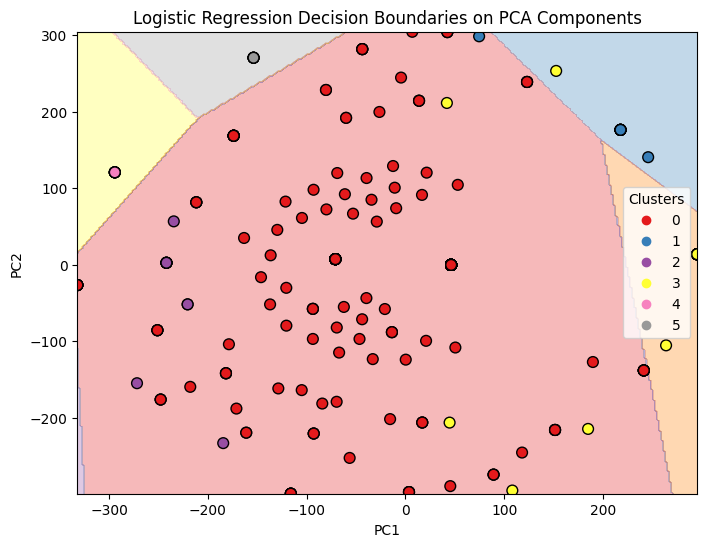

In [95]:
# We use the already prepared tsne_df from previous t-SNE reduction step on TF-IDF vectors
X = tsne_df[['TSNE_1', 'TSNE_2']].values
y = tsne_df['Cluster'].values


# Fit the logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X, y)

# Create a grid of points that covers the PCA feature space
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Predict cluster labels for each grid point
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Set1')

# Overlay the actual PCA points
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1', edgecolor='k', s=60)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Logistic Regression Decision Boundaries on PCA Components')

# Add legend for cluster labels
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


In [96]:
# If 'skills' column contains string representations of lists, convert them:
def clean_skills(x):
    if isinstance(x, str):
        try:
            # convert stringified list to list
            x = ast.literal_eval(x)
        except:
            pass
    if isinstance(x, list):
        return " ".join(x)
    return str(x)

df = df_clustered_tfidf.copy()
df['skills_clean'] = df['skills'].apply(clean_skills)

tfidf_matrix = vectorizer.fit_transform(df['skills_clean'])

# --- Step 3: Perform LDA ---
n_topics = 5  # you can tune this number based on coherence or domain knowledge
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42
)
lda_topics = lda.fit_transform(tfidf_matrix)

# --- Step 4: Add topic distributions as new columns ---
for i in range(n_topics):
    df[f'topic_{i+1}'] = lda_topics[:, i]

# --- Step 5: (Optional) Inspect top words per topic ---
def get_top_words(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics[f'Topic_{topic_idx+1}'] = top_features
    return topics

top_words = get_top_words(lda, vectorizer.get_feature_names_out(), 10)

print("Top words per topic:")
for topic, words in top_words.items():
    print(f"{topic}: {', '.join(words)}")

# --- Step 6: View updated dataframe ---
print(df.head())

Top words per topic:
Topic_1: management, project, engineering, communication, and, skills, construction, process, design, analysis
Topic_2: javascript, html, python, sql, java, css, spring, design, net, redux
Topic_3: linux, scripting, infrastructure, ci, cloud, cd, code, continuous, shell, development
Topic_4: data, analysis, sql, excel, power, analytics, modeling, tableau, bi, visualization
Topic_5: react, js, typescript, aws, angular, node, java, docker, development, kubernetes
       job_id                       title  \
0  2234533717         Full Stack Engineer   
1  2269442456          Computer Scientist   
2  2314566469        Front end specialist   
3  2735151240  Intern- Business Analytics   
4  3045980831            Project Engineer   

                                         description  \
0  Location: Remote\nCompany Overview:SkillFit, a...   
1  Are you passionate about developing cutting-ed...   
2  Regional law firm looking for a candidate with...   
3  Summer Internsh

In [98]:
df = df.merge(final_df[['job_id', 'formatted_work_type',  'views_bin']])
# cluster_cols = [f'cluster_{i}_count' for i in range(0, K)]
cluster_count = [i for i in range(0, 7)]
lda_cols = [f'topic_{i}' for i in range(1, 6)]

X = df[ lda_cols + [ 'formatted_work_type', 'general job classification']]
y = df['views_bin']

# Use stratify=y to maintain class proportions in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    random_state=0,
    train_size=0.8,
    stratify=y
)

print('Size of training set = %d and test set = %d' % (y_train.size, y_test.size))

Size of training set = 580 and test set = 145


In [99]:
# One-hot encode categorical features
col_dummny = ['formatted_work_type',  'general job classification']
numeric_cols = [col for col in X.columns if col not in col_dummny]
# 1. Initialize the OneHotEncoder within a ColumnTransformer
# The 'handle_unknown="ignore"' tells the encoder to ignore (set to 0) 
# any categories in the test set that were not seen in the training set.
# 'drop='first'' mimics the behavior of drop_first=True in pd.get_dummies
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', 
         OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), 
         col_dummny),
         ('scaler',  MinMaxScaler(), numeric_cols)
    ],
    remainder='passthrough' # Keep other columns as they are
)

# 2. FIT the preprocessor ONLY on the training data
preprocessor.fit(X_train)

# 3. TRANSFORM both the training and test data
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Convert the resulting NumPy arrays back to DataFrames for modeling, 
# ensuring consistent column names.
feature_names = preprocessor.get_feature_names_out()

# Create DataFrames with the new column names
X_train = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)
X_test = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)

/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Grid of parameters to choose from
parameters = {
    "max_depth": [5, 10, 15, 20, 30, 40, None],
    "max_leaf_nodes": [None, 50, 100, 200],
    "min_samples_split": [2, 10, 30],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Run the grid search
grid_obj = GridSearchCV(rf_model, parameters, cv=5,scoring='f1_weighted',n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_model = grid_obj.best_estimator_

# Train the Model
print("Training Random Forest Classifier...")
rf_model.fit(X_train, y_train)
print("Training Complete.")

# print parameters of rf model
print("Best parameters found:", grid_obj.best_params_)
print("Best cross-validation score:", grid_obj.best_score_)
print("Best estimator:", grid_obj.best_estimator_)

Training Random Forest Classifier...
Training Complete.
Best parameters found: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 50, 'min_samples_split': 10}
Best cross-validation score: 0.316360124984953
Best estimator: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, max_leaf_nodes=50, min_samples_split=10,
                       random_state=42)
